# Create an input data set of $a_0$ and $\rho(z)$ for the vKdV model

In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
#from mpl_toolkits.axisartist.
from matplotlib.collections import LineCollection

from glob import glob

from matplotlib import rcParams

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
%matplotlib inline

In [3]:
# Set font sizes
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

In [4]:
def double_tanh_6(beta, z):
    
    return beta[0,...] - beta[1,...]*(np.tanh((z+beta[2,...])/beta[3,...])
                + np.tanh((z+beta[2,...] + beta[4,...])/beta[5,...]))

In [5]:
def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

In [6]:
def load_density_h5(h5file):
    f = h5py.File(h5file,'r')
    rho = f['rho'][:]
    depth = f['depth'][:]
    data = f['beta_samples'][:]
    time = f['time'][:].astype('<M8[ns]')
    f.close()
    return data,time, rho, depth

def load_density_h5_stan(h5file):
    f = h5py.File(h5file,'r')
    #print(f['data'].items)
    data = f['data']['beta_samples'][:]
    time = f['data']['time'][:]
    f.close()
    return data,time

def load_density_xr(h5file, isstan=True,time=None):
    if isstan:
        data,timefile = load_density_h5_stan(h5file)
        if time is None:
            time = timefile

    else:
        data,time, rho, depth = load_density_h5(h5file)

    nparams, nt, ntrace = data.shape
    dims3 = ('params','time','ensemble')

    coords3 = {'time':time, 'ensemble':range(ntrace), 'params':range(nparams)}



    beta_da = xr.DataArray(data,
        coords=coords3,
        dims=dims3,
        attrs={'long_name':'', 'units':''},
        )

    return xr.Dataset({'beta':beta_da,})

In [7]:
!ls /home/suntans/cloudstor/Data/IMOS/*.h5

/home/suntans/cloudstor/Data/IMOS/2018-05-04_beta-samples-array.h5
/home/suntans/cloudstor/Data/IMOS/2018-05-22_beta-samples-array-all-data.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_beta-samples-array-all-data.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_density_bhm_4params_2018-12-18.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-13.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-16.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-18.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-19.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_density_bhm_7params_2018-12-13.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_12mth_Density_lowpass_density_bhm_7params_2018-12-16.h5
/home/suntans/cloudstor/Data/IMOS/Crux_KP150_AprMay2

In [8]:
###########
# Inputs
datadir = '/home/suntans/cloudstor/Data/IMOS/'
#datadir = '../../run_ddcurves/DATA_SHELL/'

#######
# Prelude files
# ddcurves BHM output file

#h5file = '%s/Crux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-19.h5'%datadir
#h5file = '%s/Crux_KP150_Phs2_Density_lowpass_density_bhm_6params_2018-12-17.h5'%datadir
#h5files = [
#   '%s/Crux_KP150_Phs1_Density_lowpass_density_bhm_6params_2018-12-17.h5'%datadir , 
#  '%s/Crux_KP150_Phs2_Density_lowpass_density_bhm_6params_2018-12-17.h5'%datadir  ]
#h5files = [
#   '%s/Crux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-16.h5'%datadir , 
#    ]
#isstan=False

datadir = '../../run_ddcurves/DATA_SHELL/'

#h5files = ['%s/Crux_KP150_Phs1_Density_lowpass_beta-samples-array-all-data.h5'%datadir,
#          '%s/Crux_KP150_Phs2_Density_lowpass_beta-samples-array-all-data.h5'%datadir]
isstan = True
# This is the good file!!!
h5files = ['%s/Crux_KP150_12mth_Density_lowpass_beta-samples-array-all-data.h5'%datadir]
csvfiles = ['%s/Crux_KP150_12mth_Density_lowpass.csv'%datadir]
outfile = None

mode = 0
nparams=6
density_func = double_tanh_6

######
# Pilbara files
#datadir = '/home/suntans/cloudstor/Data/IMOS/'
#h5files = sorted(glob('%s/IMOS_Density_PIL200_20*_6params*.h5'%datadir) )
# isstan = False
#outfile = '../data/vkdv_inputs_imospil200.csv'
#outfile = '../data/vkdv_inputs_mode%d_imospil200.csv'%(mode+1)

#ncfile = '%sCrux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-19_nliw.nc'%datadir
h5files

['../../run_ddcurves/DATA_SHELL//Crux_KP150_12mth_Density_lowpass_beta-samples-array-all-data.h5']

In [9]:
#load_density_xr(h5file,isstan=False)

In [10]:
# Need to get the raw data and time from the csv file



In [11]:
#f = h5py.File(h5file,'r')
#for kk in f['data'].keys():
#    print(kk)
#print(f['depth'][:].min())
#f.close()
#load_density_h5_stan(h5file)

# Load a group of hdf5 files
csv = pd.read_csv(csvfiles[0],sep=', ',index_col='Time', parse_dates=['Time'])
time = [cc.to_datetime64() for cc in csv.index]
ds = load_density_xr(h5files[0],isstan=isstan, time=time)
#for h5file in h5files[1:]:
#    ds = xr.concat([ds,load_density_xr(h5file,isstan=isstan)], dim='time')
ds

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


<xarray.Dataset>
Dimensions:   (ensemble: 1500, params: 6, time: 1480)
Coordinates:
  * time      (time) datetime64[ns] 2016-04-29T23:15:00 ... 2017-05-06T12:40:00
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 ... 1494 1495 1496 1497 1498 1499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    beta      (params, time, ensemble) float64 1.023e+03 1.024e+03 ... 49.27

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


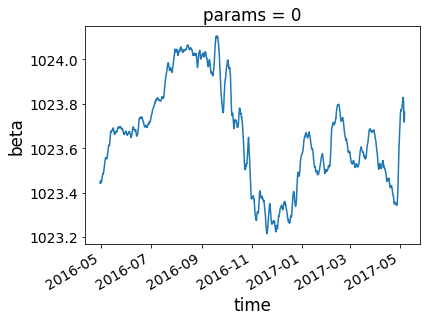

In [12]:
plt.figure()
ds.beta[0,:,:].median(axis=-1).plot()

In [13]:
# Load the amplitude and density data

ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two
A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan
a0.loc['2016-09-18':'2016-10-31']=np.nan


# Create a time series of single days with the max amplitude and a guess at beta
time1 = pd.date_range('2016-5-1','2016-9-15') 
time2 = pd.date_range('2016-11-1','2017-5-1')

time = time1.append(time2)
#time = time2
time 

DatetimeIndex(['2016-05-01', '2016-05-02', '2016-05-03', '2016-05-04',
               '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
               '2016-05-09', '2016-05-10',
               ...
               '2017-04-22', '2017-04-23', '2017-04-24', '2017-04-25',
               '2017-04-26', '2017-04-27', '2017-04-28', '2017-04-29',
               '2017-04-30', '2017-05-01'],
              dtype='datetime64[ns]', length=320, freq=None)

In [14]:
ds1

<xarray.Dataset>
Dimensions:   (freqs: 3, modes: 4, time: 264601, timeslow: 728, z: 100)
Coordinates:
  * modes     (modes) int64 0 1 2 3
  * time      (time) datetime64[ns] 2016-04-30 ... 2016-10-30T18:00:00
  * z         (z) float64 0.0 -2.525 -5.051 -7.576 ... -244.9 -247.5 -250.0
  * timeslow  (timeslow) datetime64[ns] 2016-05-01 ... 2016-10-29T18:00:00
  * freqs     (freqs) float64 0.0001405 0.000281 0.0004216
Data variables:
    Atide     (time, modes) float64 ...
    phi       (timeslow, modes, z) float64 ...
    rhofit    (time, z) float64 ...
    r10       (timeslow, modes) float64 ...
    rhobar    (timeslow, z) float64 ...
    amp       (timeslow, modes, freqs) float64 ...
    phs       (timeslow, modes, freqs) float64 ...
    A_n       (time, modes) float64 ...
    N2        (timeslow, z) float64 ...
    cn        (timeslow, modes) float64 ...
Attributes:
    Y:            -13.75895
    ncfile:       /home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Gridd...
    group: 

In [15]:
# Get the unique days from the time series
#dates = pd.DatetimeIndex(A_n["time"].values)#
#time = dates.map(lambda t: t.date()).unique()
#time


In [16]:
if outfile is not None:
    f=open(outfile,'w')
outstr = 'time, timemax, Amax, beta0, beta1, beta2, beta3, beta4, beta5'
print(outstr)

Amax_all = []
Tmax = []
if outfile is not None:
    f.write(outstr+'\n')
for t1,t2 in zip(time[0:-1],time[1::]):
    A = A_n.sel(time=slice(t1,t2))
    
    # Find the amplitude
    try:
        Amax,idx = maximum_amplitude_finder(A.values)
    except:
        continue
    
    #plt.figure()
    #A.plot()
    #plt.plot(A.time.values[idx],Amax,'mo')
    
    # Find a representative (median) beta
    dsc=ds.sel(time=t2,method='nearest')
    meanbeta = dsc.beta.median(axis=-1).values
    #print('{}, {}, {}'.format(t1, A.time.values[idx], Amax, ))
    outstr = '%s, %s, %3.3f'%(t1, A.time.values[idx], Amax, )
    for bb in meanbeta:
        outstr +=', %3.3f'%bb

    print(outstr)
    if outfile is not None:
        f.write(outstr+'\n')
        
    Amax_all.append(Amax)
    Tmax.append( A.time.values[idx])
    #print('{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(t1, A.time.values[idx], Amax, dsc.beta.mean(axis=-1).values) )

if outfile is not None:    
    f.close()
    print('Written to %s'%outfile)


time, timemax, Amax, beta0, beta1, beta2, beta3, beta4, beta5
2016-05-01 00:00:00, 2016-05-01T22:49:00.000000000, -17.517, 1023.458, 1.313, 59.003, 28.810, 144.098, 47.826
2016-05-02 00:00:00, 2016-05-02T17:26:00.000000000, -16.563, 1023.480, 1.317, 58.644, 30.436, 146.120, 50.880
2016-05-03 00:00:00, 2016-05-03T20:50:00.000000000, 19.584, 1023.491, 1.317, 59.199, 29.529, 146.793, 53.237
2016-05-04 00:00:00, 2016-05-04T23:28:00.000000000, 25.726, 1023.514, 1.316, 59.072, 29.705, 148.775, 55.677
2016-05-05 00:00:00, 2016-05-05T18:50:00.000000000, -26.879, 1023.546, 1.315, 59.352, 31.021, 150.435, 57.744
2016-05-06 00:00:00, 2016-05-06T12:55:00.000000000, 30.651, 1023.552, 1.311, 59.075, 33.332, 150.477, 56.462
2016-05-07 00:00:00, 2016-05-07T01:15:00.000000000, 30.756, 1023.554, 1.315, 54.849, 35.215, 150.172, 55.644
2016-05-08 00:00:00, 2016-05-08T14:38:00.000000000, 31.698, 1023.570, 1.319, 53.357, 35.449, 149.017, 56.922
2016-05-09 00:00:00, 2016-05-09T02:06:00.000000000, 29.354, 102

2016-07-15 00:00:00, 2016-07-15T11:26:00.000000000, -16.206, 1023.824, 1.008, 128.316, 39.110, 157.975, 46.027
2016-07-16 00:00:00, 2016-07-16T23:59:00.000000000, -19.127, 1023.844, 1.002, 129.370, 38.565, 156.563, 45.981
2016-07-17 00:00:00, 2016-07-17T00:04:00.000000000, -20.963, 1023.883, 1.015, 125.809, 38.805, 155.629, 47.133
2016-07-18 00:00:00, 2016-07-18T14:22:00.000000000, -21.309, 1023.915, 1.027, 120.539, 42.376, 153.169, 48.295
2016-07-19 00:00:00, 2016-07-19T20:45:00.000000000, 23.286, 1023.942, 1.032, 115.766, 45.510, 154.487, 48.413
2016-07-20 00:00:00, 2016-07-20T04:22:00.000000000, -23.481, 1023.969, 1.040, 113.660, 44.351, 156.731, 49.978
2016-07-21 00:00:00, 2016-07-21T03:27:00.000000000, -24.817, 1023.985, 1.047, 110.977, 43.910, 155.627, 51.280
2016-07-22 00:00:00, 2016-07-22T06:02:00.000000000, -22.775, 1023.969, 1.054, 103.858, 44.971, 154.876, 53.679
2016-07-23 00:00:00, 2016-07-23T06:14:00.000000000, -27.271, 1023.950, 1.052, 93.437, 42.296, 157.000, 53.969
201

2016-11-16 00:00:00, 2016-11-16T17:04:00.000000000, -22.059, 1023.323, 1.223, 65.050, 61.433, 158.964, 45.658
2016-11-17 00:00:00, 2016-11-17T11:47:00.000000000, 24.959, 1023.271, 1.238, 60.125, 62.609, 158.299, 44.893
2016-11-18 00:00:00, 2016-11-18T15:45:00.000000000, -24.628, 1023.224, 1.250, 58.196, 61.984, 157.367, 42.445
2016-11-19 00:00:00, 2016-11-19T17:18:00.000000000, -26.736, 1023.225, 1.243, 60.079, 61.950, 158.015, 40.994
2016-11-20 00:00:00, 2016-11-20T17:56:00.000000000, -25.127, 1023.271, 1.217, 64.826, 62.883, 157.381, 39.938
2016-11-21 00:00:00, 2016-11-21T17:37:00.000000000, -29.649, 1023.315, 1.198, 72.050, 61.339, 155.580, 42.417
2016-11-22 00:00:00, 2016-11-22T19:24:00.000000000, -21.780, 1023.350, 1.184, 80.352, 59.467, 152.697, 44.426
2016-11-23 00:00:00, 2016-11-23T08:00:00.000000000, -22.388, 1023.305, 1.186, 78.267, 60.702, 150.145, 40.927
2016-11-24 00:00:00, 2016-11-24T20:30:00.000000000, -15.855, 1023.266, 1.199, 72.283, 59.469, 150.555, 38.135
2016-11-25 

2017-01-30 00:00:00, 2017-01-30T06:18:00.000000000, -18.694, 1023.499, 1.103, 65.113, 52.028, 151.183, 48.466
2017-01-31 00:00:00, 2017-01-31T13:22:00.000000000, 21.344, 1023.501, 1.113, 64.055, 52.748, 152.517, 49.491
2017-02-01 00:00:00, 2017-02-01T13:32:00.000000000, 20.431, 1023.505, 1.132, 64.380, 52.720, 154.826, 50.094
2017-02-02 00:00:00, 2017-02-02T16:41:00.000000000, -23.853, 1023.521, 1.146, 66.292, 52.780, 158.121, 50.797
2017-02-03 00:00:00, 2017-02-03T17:29:00.000000000, -36.384, 1023.524, 1.160, 66.742, 54.816, 161.077, 50.113
2017-02-04 00:00:00, 2017-02-04T17:53:00.000000000, -30.962, 1023.554, 1.185, 65.715, 53.008, 160.877, 52.198
2017-02-05 00:00:00, 2017-02-05T19:28:00.000000000, -28.345, 1023.650, 1.212, 67.015, 52.239, 160.892, 56.131
2017-02-06 00:00:00, 2017-02-06T20:51:00.000000000, -22.567, 1023.698, 1.213, 68.885, 53.975, 161.964, 56.841
2017-02-07 00:00:00, 2017-02-07T23:17:00.000000000, -23.698, 1023.709, 1.184, 71.823, 53.367, 161.315, 56.652
2017-02-08 0

2017-04-22 00:00:00, 2017-04-22T11:56:00.000000000, -14.080, 1023.385, 1.224, 62.690, 55.417, 157.540, 37.259
2017-04-23 00:00:00, 2017-04-23T19:32:00.000000000, 17.421, 1023.356, 1.232, 59.809, 54.408, 154.211, 35.443
2017-04-24 00:00:00, 2017-04-24T20:37:00.000000000, 17.527, 1023.353, 1.234, 58.109, 53.781, 153.289, 35.269
2017-04-25 00:00:00, 2017-04-25T14:40:00.000000000, -20.215, 1023.352, 1.221, 57.955, 54.565, 151.097, 35.191
2017-04-26 00:00:00, 2017-04-27T00:00:00.000000000, 20.388, 1023.348, 1.215, 56.831, 54.540, 149.722, 34.070
2017-04-27 00:00:00, 2017-04-27T08:33:00.000000000, 21.397, 1023.377, 1.208, 60.016, 56.342, 150.719, 36.494
2017-04-28 00:00:00, 2017-04-28T12:51:00.000000000, 24.509, 1023.503, 1.144, 80.751, 61.923, 153.673, 39.649
2017-04-29 00:00:00, 2017-04-29T19:52:00.000000000, -29.912, 1023.626, 1.072, 105.778, 58.035, 154.483, 41.596
2017-04-30 00:00:00, 2017-04-30T23:51:00.000000000, 34.005, 1023.722, 1.093, 106.412, 55.697, 151.280, 45.205


In [20]:
Amax_pd=pd.Series(Amax_all,index=Tmax)

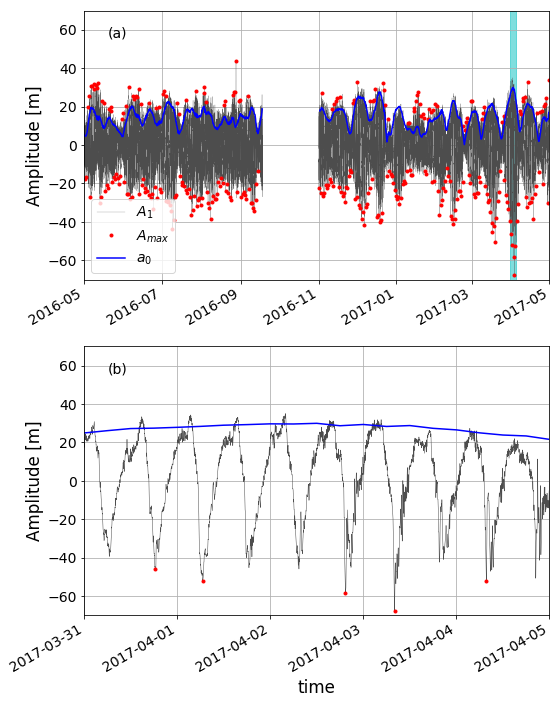

In [17]:
t0,t1 = datetime(2017,3,31),datetime(2017,4,5)
# Make a figure with A_n, a_0, peaks, eta
plt.figure(figsize=(8,10))

ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(color='0.3',lw=0.2)
plt.plot(Tmax,Amax_all,'r.', )
plt.ylim(-70,70)
plt.grid(b=True)
plt.ylabel('Amplitude [m]')
plt.title('')
plt.xlim([time[0],time[-1]])
plt.plot(a0.timeslow,a0.values,'b')
#plt.fill_between(a0.timeslow.values,a0.values,y2=-a0.values,color='b',alpha=0.2)

plt.legend(('$A_1$','$A_{max}$','$a_0$'),loc='lower left')
plt.tight_layout()
plt.xlabel('')
plt.fill([t0,t1,t1,t0,t0],[-70,-70,70,70,-70],c='c',alpha=0.5)
plt.text(0.05,0.9,'(a)', transform=ax1.transAxes)

ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
A_n.plot(color='0.3',lw=0.5)
plt.plot(Tmax,Amax_all,'r.', )
plt.ylim(-70,70)
plt.grid(b=True)
plt.ylabel('Amplitude [m]')
plt.title('')
plt.xlim([t0,t1])
plt.plot(a0.timeslow,a0.values,'b')
#plt.plot(a0.timeslow,-a0.values,'b')

#plt.fill_between(a0.timeslow.values,a0.values,y2=-a0.values,color='b',alpha=0.2)

plt.text(0.05,0.9,'(b)', transform=ax2.transAxes)
plt.tight_layout()

# plt.savefig('../FIGURES/Amax_a0_timeseries.png',dpi=150)
# plt.savefig('../FIGURES/Amax_a0_timeseries.pdf',dpi=150)

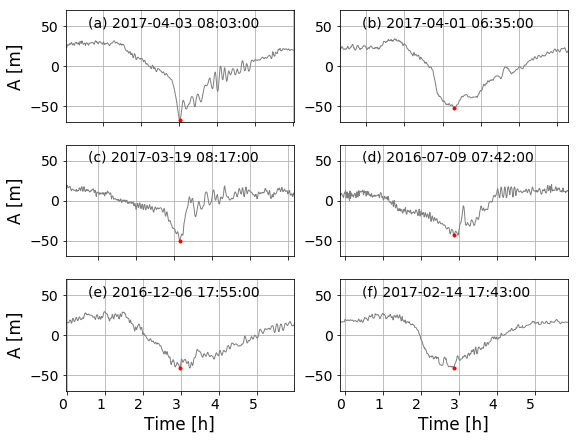

In [69]:
# Plot the six biggest waves
sidx = np.argsort(Amax_all)

idx  = [0,3,4,7,9,10]
plt.figure(figsize=(9,7))

for kk in range(6):
    ii = idx[kk]
    ax=plt.subplot(3,2,kk+1)
    t1= Tmax[sidx[ii]]-np.timedelta64(6*3600,'s')
    t2 = Tmax[sidx[ii]]+np.timedelta64(6*3600,'s')
    
    A_n.plot(color='0.5',lw=1)
    plt.plot(Tmax,Amax_all,'r.', )
    plt.ylim(-70,70)
    plt.grid(b=True)
    plt.ylabel('')
    plt.title('')
    plt.xlim([t1,t2])
    plt.xlabel('')
    ax.set_xticklabels([])
    plt.text(0.1,0.85, '({}) {}'.format(chr(97+kk), Tmax[sidx[ii]].astype(str)[0:19].replace('T',' ')),transform=ax.transAxes)
    
    if kk in [4,5]:
        plt.xlabel('Time [h]')
        ax.set_xticklabels(range(0,6))
        plt.xticks(rotation=0)
        
    if kk in [0,2,4]:
        plt.ylabel('A [m]')
        
plt.savefig('../FIGURES/Amax_examples.png',dpi=150)
plt.savefig('../FIGURES/Amax_examples.pdf',dpi=150)        

In [36]:
for ii in range(0,15):
    print(ii, Tmax[sidx[ii]])

0 2017-04-03T08:03:00.000000000
1 2017-04-02T19:24:00.000000000
2 2017-04-04T07:44:00.000000000
3 2017-04-01T06:35:00.000000000
4 2017-03-19T08:17:00.000000000
5 2017-03-31T18:23:00.000000000
6 2017-03-17T06:22:00.000000000
7 2016-07-09T07:42:00.000000000
8 2017-03-18T19:15:00.000000000
9 2016-12-06T17:55:00.000000000
10 2017-02-14T17:43:00.000000000
11 2017-03-16T18:14:00.000000000
12 2016-12-18T17:11:00.000000000
13 2017-04-05T09:10:00.000000000
14 2017-03-30T17:06:00.000000000
